# $$
\text{Résolution approchée des équations différentielles ordinaires}
$$

### Objectifs :

- implémenter les méthodes d'Euler explicite et implicite et mettre en évidence leur ordre de convergence ;
- implémenter les méthodes de Runge-Kutta d'ordre deux et d'ordre quatre ;
- utiliser des routines de scipy pour la résolution approchée d'équations différentielles ordinaires ;
- représenter numériquement des portraits de phase.

##  I. Méthodes d'Euler

### 1. Méthode d'Euler explicite

Considérons l'équation différentielle
$$
\begin{cases} x'(t) = f(x(t),t), \\ x(0) = x_0, \end{cases}
$$
pour une condition initiale $x_0 \in \mathbb{R}^n$. Étant donné un temps $t > 0$, nous cherchons à calculer numériquement la valeur de $x(t)$. Pour un nombre de discrétisations $K$ et un pas de temps associé $h = t/K$, la méthode d'Euler explicite consiste à calculer la suite $(x_k)_{0 \leq k \leq K}$ suivant la relation :
$$
\forall 0 \leq k \leq K - 1, \, x_{k + 1} = x_k + h f(x_k, k h),
$$
afin d'approcher les valeurs $(x(k h))_{0 \leq k \leq K}$. En particulier, le nombre $x_K$ donnera une valeur approchée du nombre $x(t)$ recherché.

La fonction `eul_exp(f,x0,t,K)` suivante prend en entrée une fonction $f : \mathbb{R}^n \times \mathbb{R} \to \mathbb{R}^n$, une position initiale $x_0 \in \mathbb{R}^n$, un temps $t$ et un nombre de discrétisation $K$, et renvoie une valeur approchée de $x(t)$ calculée à l'aide du schéma d'Euler explicite pour un pas de temps $h = t/K$ :

In [1]:
import numpy as np
def eul_exp(f,x0,t,K):
    y=np.copy(x0)     # représente initialement le vecteur x0
    h=t/K
    for k in range(K):
        y=y+h*f(y,k*h)     # puis représente l'itéré x_{k+1} de l'algorithme d'Euler explicite pour k entre 0 et K-1
    return(y)
# Test de la fonction eul_exp pour l'équation différentielle x'(t)=x(t)-x^3(t)+t et la donnée initiale x(0)=4
def f1(x,t):
    return x-x**3+t
x01=4
print('x(5) =',eul_exp(f1,x01,5,1000),'\n')

x(5) = 1.8935888442548368 



Pour représenter l'ensemble des valeurs prises sur le segment $[0, t]$, il convient de garder toutes les valeurs $(x_k)_{0\leq k \leq K}$. La fonction `eul_exp2(f,x0,t,K)` suivante renvoie la matrice $X$ dont la $k$-ième ligne est le vecteur $x_k$ calculé à l'aide du schéma d'Euler explicite pour un pas de temps $h = t/K$ :

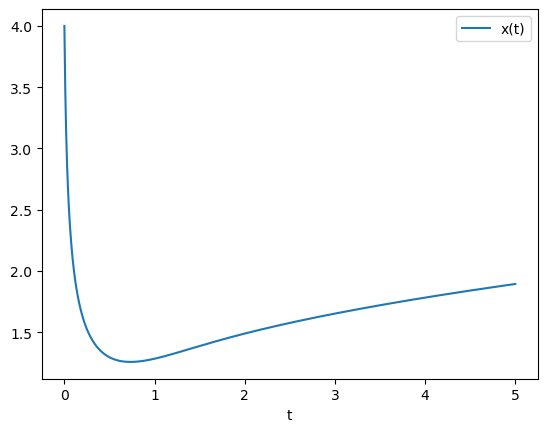

In [2]:
def eul_exp2(f,x0,t,K):
    n=len(x0)
    X=np.zeros([K+1,n])
    X[0]=x0     # représente le vecteur x0
    h=t/K
    for k in range(K):
        X[k+1]=X[k]+h*f(X[k],k*h)     # représente l'itéré x_{k+1} de l'algorithme d'Euler explicite pour k entre 0 et K-1
    return(X)
# Test de la fonction eul_exp2 pour l'équation différentielle x'(t)=x(t)-x^3(t)+t et la donnée initiale x(0)=4
from matplotlib import pyplot as plt
def f2(x,t):
    return np.array([x[0]-x[0]**3+t])
x02=np.array([4])
X2=eul_exp2(f2,x02,5,1000)
T2=np.linspace(0,5,1001)
plt.plot(T2,X2,label='x(t)')
plt.xlabel('t')
plt.legend()
plt.show()

### 2. Méthode d'Euler implicite

Nous cherchons toujours à résoudre l'équation différentielle
$$
\begin{cases} x'(t)=f(x(t),t), \\ x(0)=x_0. \end{cases}
$$
Étant donné un pas de temps $h=t/K$, et connaissant une valeur approchée $x_k$ de la solution $x$ au temps $t_k=k h$, nous calculons une valeur approchée au temps $t_{k+1} = (k + 1) h$ en résolvant l'équation :
$$
x_{k+1} = x_k + h f(x_{k+1}, t_{k+1}).
$$
Cette équation s'écrit comme un système non-linéaire de la forme :
$$
F_{x_k, t_{k+1}, h}(x_{k+1}) = 0,
$$
avec
$$
F_{x, t, h}(y) = y - x - h f(y, t).
$$
Nous pouvons résoudre ce système non-linéaire à l'aide de l'algorithme de Newton-Raphson qui requiert que la fonction $F_{x_k, t_{k+1}, h}$ soit a minima différentiable. Nous supposons donc que la fonction $f$ est différentiable par rapport à sa première variable, auquel cas la matrice Jacobienne de $F_{x_k, t_{k+1}, h}$ est donnée par la formule :
$$
JF_{x_k, t_{k+1}, h}(x_{k+1})(y) = Id - h J_x f(y, t).
$$
Dans cette expression, la notation $J_xf(y,t)$ désigne la matrice Jacobienne de $f$ par rapport à sa première variable.

Sur le plan numérique, nous commençons par rappeler le code suivant de l'algorithme de Newton-Raphson :

In [3]:
def new_rap(F,JF,x0,eps,N):
    e=2*eps
    n=0
    x=x0
    while e>eps and n<N:
        x=x-np.linalg.solve(JF(x),F(x))
        e=np.linalg.norm(F(x))
        n=n+1
    if n<N:
        return(x)
    else:
        return("L'algorithme n'a pas convergé.")

La fonction `eul_imp(f,Jxf,x0,t,K,eps,N)` suivante prend en entrée une fonction $f$, sa différentielle par rapport à la première variable $J_xf$, une donnée initiale $x_0$, un temps $t$, un nombre de discrétisations $K$, ainsi qu'un seuil d'erreur $\epsilon$ et un nombre maximal d'itération $N$ pour l'appel de la fonction `new_rap` dont le code est ci-dessus :

In [4]:
def eul_imp(f,Jxf,x0,t,K,eps,N):
    n=len(x0)
    y=np.copy(x0)        # représente initialement le vecteur x0
    h=t/K
    for k in range(K):
        def F_aux(x):       # représente la fonction F_{x_k,t_{k+1},h}
            return(x-h*f(x,(k+1)*h)-y)
        def JF_aux(x):
            return(np.identity(n)-h*Jxf(x,(k+1)*h))   # représente la matrice Jacobienne JF_{x_k,t_{k+1},h}
        z=new_rap(F_aux,JF_aux,y,eps,N)    # applique l'algorithme de Newton-Raphson avec y=x_k
        y=z              # met à jour la valeur de y comme égale à l'itéré x_{k+1}
    return(y)
# Test de la fonction eul_imp pour l'équation différentielle x'(t)=x(t)-x^3(t)+t et la donnée initiale x(0)=4
def Jxf2(x,t):
    return(np.array([1-3*x[0]**2]))
print('x(5) =',eul_imp(f2,Jxf2,x02,5,1000,0.0001,1000)[0],'\n')

x(5) = 1.893582016959446 



## II. Les méthodes de Runge-Kutta

Le but est d'introduire une classe de méthodes plus précises que les méthodes d'Euler explicite et implicite pour résoudre l'équation différentielle précédente. Au lieu d'approcher au premier ordre en $h$, le principe est d'approcher à un ordre supérieur.

Étant donné un temps $0 < T < T_\max$, où $T_\max$ est le temps maximal d'existence de la solution $x$, nous commençons comme pour les méthodes d'Euler explicite et implicite par définir un pas de temps $h = T/K$ et par discrétiser l'intervalle en des temps $(t_0, t_1, \ldots, t_K)$ avec $t_k = k h$.

Le principe est alors de construire des valeurs approchées $x_k$ au temps $t_k$ pour chaque $0 \leq k \leq K$ suivant le schéma à un pas :
$$
x_0 = x_0, \quad \text{ et } \quad x_{k+1} = x_k + \phi(f, x_k, t_k, h),
$$
dans laquelle la fonction $\phi$ caractérise la méthode considérée. Pour la méthode d'Euler explicite, cette fonction est donnée par :
$$
\phi(f, x, t, h) = h f(x, t).
$$
Pour la méthode de Runge-Kutta d'ordre deux, elle vaut:
$$
\phi(f, x, t, h) = h f \big( x + \frac{h}{2} f(x,t), t + \frac{h}{2} \big),
$$
tandis que pour la méthode de Runge-Kutta d'ordre quatre, elle est donnée par :
$$
\phi(f, u, t, h) = \frac{h}{6} \big( \boldsymbol{k}_1 + 2 \boldsymbol{k}_2 + 2 \boldsymbol{k}_3 + \boldsymbol{k}_4 \big),
$$
où
\begin{align*}
& \boldsymbol{k}_1 = f(x,t), \\
& \boldsymbol{k}_2 = f \big( x + \frac{h}{2} \boldsymbol{k}_1, t + \frac{h}{2} \big), \\ 
& \boldsymbol{k}_3 = f \big( x + \frac{h}{2} \boldsymbol{k}_2, t + \frac{h}{2} \big), \\ 
& \boldsymbol{k}_4 = f(x + h \boldsymbol{k}_3, t + h).
\end{align*}

Plus généralement, une méthode de Runge-Kutta d'ordre $s$ est donnée par les formules :
$$
\phi(f, x, t, h) = h \sum_{i=1}^s b_i \boldsymbol{k}_i,
$$
où
\begin{align*}
& \boldsymbol{k}_1 = f(x, t), \\ 
& \boldsymbol{k}_2 = f(x + h a_{21} \boldsymbol{k}_1, t + c_2 h), \\ 
& \boldsymbol{k}_3 = f(x + h (a_{31} \boldsymbol{k}_1 + a_{32} \boldsymbol{k}_2), t + c_3 h), \\ 
& \ldots = \ldots, \\ 
& \boldsymbol{k}_s = f(x + h (a_{s1} \boldsymbol{k}_1 +a_{s2}\boldsymbol{k}_2 + \ldots + a_{s,s-1} \boldsymbol{k}_{s-1}), t + c_s h).
\end{align*}
Les coefficients $(a_{ij})_{1 \leq j < i \leq s}$, $(c_i)_{2 \leq i \leq s}$, et $(b_i)_{1 \leq i \leq s}$ sont souvent représentés par un tableau dit de Butcher :
$$
\begin{array}{c|ccccc}
0\\ 
c_{2} & a_{21}\\ 
c_{3} & a_{31} & a_{32}\\ 
\vdots & \vdots &  & \ddots\\ 
c_{s} & a_{s1} & a_{s2} & \cdots & a_{s,s-1}\\ 
\hline  & b_{1} & b_{2} & \cdots & b_{s-1} & b_{s}
\end{array}
$$
Par exemple, les tableaux de Butcher des méthodes d'ordre deux et d'ordre quatre sont :
$$
\begin{array}{c|cc}
0\\ 
\frac{1}{2} & \frac{1}{2}\\ 
\hline  & 0 & 1
\end{array}
$$
et :
$$
\begin{array}{c|cccc}
0\\ 
\frac{1}{2} & \frac{1}{2}\\ 
\frac{1}{2} & 0 & \frac{1}{2}\\ 
1 & 0 & 0 & 1\\ 
\hline  & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}
$$
Nous renvoyons aux exercices ci-dessous pour l'implémentation de ces méthodes.

## III. La routine de scipy.integrate

La routine `scipy.integrate.odeint(f,x0,t)` prend en entrée une fonction $f$, une donnée initiale $x_0$ et un vecteur de temps $t = (t_0, \ldots, t_{n-1})$, et renvoie le vecteur $(x(t_0), x(t_1), \ldots, x(t_{n-1}))$ des valeurs de la solution aux temps $t_0$, $t_1$, $\ldots$, et $t_{n-1}$.

**Attention !** Même pour une équation différentielle autonome, la fonction $f$ doit être écrite comme une fonction de deux variables $(x, t)$.

Observons que la fonction `scipy.integrate.odeint` fonctionne dans le cas vectoriel : l'argument $x$ peut etre un tableau de numpy et la fonction $f$ à valeurs dans l'ensemble des tableaux de numpy. Notons aussi qu'il est permis d'ajouter d'autres arguments à `scipy.integrate.odeint`. Pour plus de détails nous renvoyons à l'aide `help('scipy.integrate.odeint')` de cette fonction.

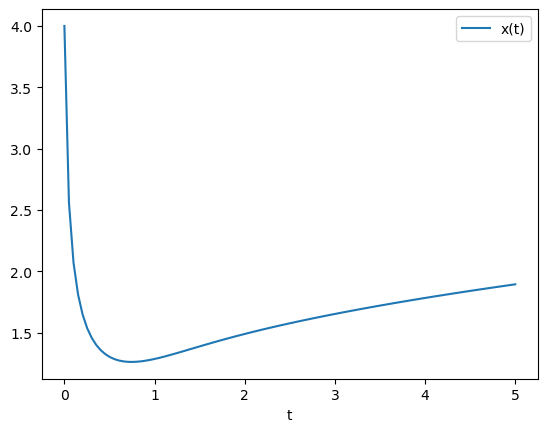

In [5]:
import scipy.integrate as sc_int
T1=np.linspace(0,5,100)
X1=sc_int.odeint(f1,x01,T1)
plt.plot(T1,X1,label='x(t)')
plt.xlabel('t')
plt.legend()
plt.show()

## IV. Représentations de portraits de phase

### 1. Trajectoires

Considérons une équation différentielle autonome
$$
x'(t) = f(x(t)).
$$
Un portrait de phase représente des trajectoires de cette équation différentielle dans l'espace des phases. Étant données des conditions initiales $(x_0^{(0)}, x_{0}^{(1)}, \ldots, x^{(n-1)}_0)$, nous traçons les courbes des valeurs prises par les solutions correspondantes $x^{(0)}(t)$, $x^{(1)}(t)$, $\ldots$, et $x^{(n-1)}(t)$ pour $t \in [0, T]$.

Étudions l'exemple de l'équation du pendule simple
$$
x''(t) = \sin(x(t)).
$$
L'introduction du vecteur $U = (x, x')$ permet de se ramener à l'équation différentielle autonome du premier ordre
$$
U'(t) = f(U(t)),
$$
avec
$$
f(u_0, u_1) = (u_1, \sin(u_0)).
$$
À l'aide de la routine `scipy.integrate.odeint`, nous pouvons tracer la solution associée à la condition initiale $U(0) = (-1, 1)$ :

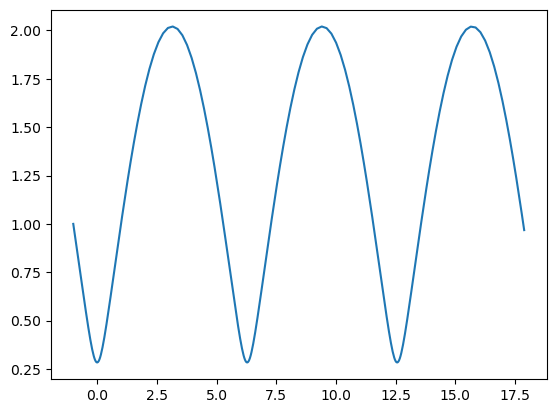

In [6]:
def f4(u,t):
    return np.array([u[1],np.sin(u[0])])
U01=np.array([-1,1])
T4=np.linspace(0,20,200)
U1=sc_int.odeint(f4,U01,T4)
plt.plot(U1[:,0],U1[:,1])
plt.show()

Nous pouvons compléter ce tracé avec d'autres trajectoires, par exemple celles correspondant aux données initiales $(-1, 2)$, $(1, 0)$, $(2, 0)$, $(3, 0)$, $(9, -2)$ et $(9,-3)$ :

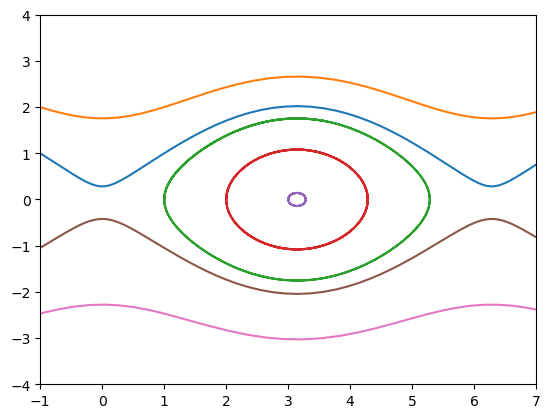

In [7]:
U02=np.array([-1,2])
U03=np.array([1,0])
U04=np.array([2,0])
U05=np.array([3,0])
U06=np.array([9,-2])
U07=np.array([9,-3])
U2=sc_int.odeint(f4,U02,T4)
U3=sc_int.odeint(f4,U03,T4)
U4=sc_int.odeint(f4,U04,T4)
U5=sc_int.odeint(f4,U05,T4)
U6=sc_int.odeint(f4,U06,T4)
U7=sc_int.odeint(f4,U07,T4)
plt.plot(U1[:,0],U1[:,1])
plt.plot(U2[:,0],U2[:,1])
plt.plot(U3[:,0],U3[:,1])
plt.plot(U4[:,0],U4[:,1])
plt.plot(U5[:,0],U5[:,1])
plt.plot(U6[:,0],U6[:,1])
plt.plot(U7[:,0],U7[:,1])
plt.xlim(-1,7)    # représentation graphique pour x entre -1 et 7
plt.ylim(-4, 4)   # représentation graphique pour y entre -4 et 4
plt.show()

### 2. Isoclines de niveau zéro

Il est parfois utile de considérer les isoclines de niveau zéro. Ce sont les ensembles où la variation temporelle d'une coordonnée est nulle : $\{ x_0' = 0 \}$, $\{x_1' = 0\}$, $\ldots$, ou $\{ x_{n-1}' = 0 \}$. Pour $f = (f_0,\ldots,f_{n-1})$, nous notons que $x_i' = 0$ si et seulement si $f_i(x) = 0$. L'ensemble $\{ x_i' = 0\}$ correspond donc à l'ensemble des zéros $\{ f_i(x) = 0 \}$ de la $i$-ième coordonnée du champ de vecteurs $f$.

Remarquons également que l'intersection de toutes les isoclines est égale à l'ensemble des points stationnaires
$$
\cap_{i=0}^{n-1} \{ x_i' = 0 \} = \{ f(x) = 0\}.
$$

Pour l'exemple du pendule simple, nous savons que
$$
\{ u_0' = 0\} = \{ u_1 = 0\}, \quad \text{ et } \quad \{u_1' = 0\} = \cup_{j \in \mathbb{Z}} \{ u_0 = \pi j \},
$$
et nous aboutissons à la représentation graphique suivante des isoclines de niveau zéro :

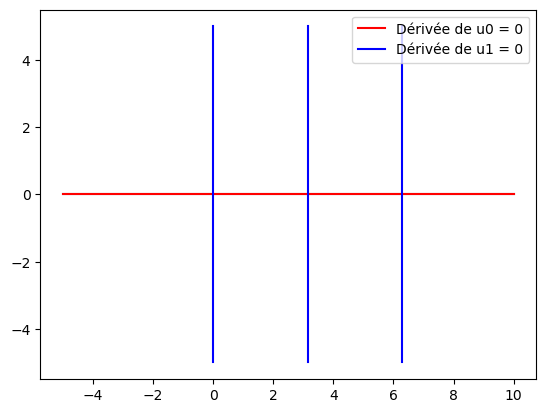

In [8]:
iso0=np.zeros([100,2])
iso0[:,0]=np.linspace(-5,10,100)
plt.plot(iso0[:,0],iso0[:,1])
iso10=np.zeros([100,2])
iso10[:,1]=np.linspace(-5,5,100)
iso11=np.pi*np.ones([100,2])
iso11[:,1]=np.linspace(-5,5,100)
iso12=2*np.pi*np.ones([100,2])
iso12[:,1]=np.linspace(-5,5,100)
plt.plot(iso0[:,0],iso0[:,1],'r',label='Dérivée de u0 = 0')
plt.plot(iso10[:,0],iso10[:,1],'b',label='Dérivée de u1 = 0')
plt.plot(iso11[:,0],iso11[:,1],'b')
plt.plot(iso12[:,0],iso12[:,1],'b')
plt.legend()
plt.show()

Nous pouvons alors représenter les isoclines de niveau $0$ et les trajectoires simultanément :

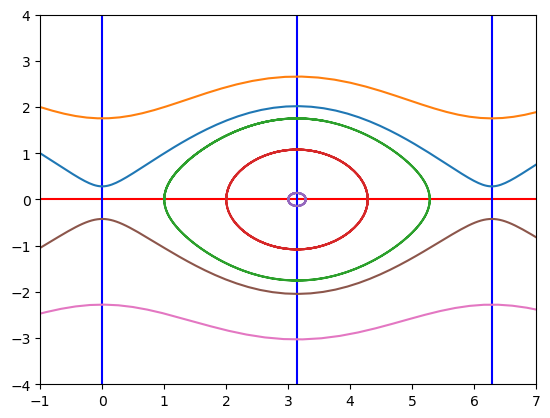

In [9]:
plt.plot(iso0[:,0],iso0[:,1],'r')
plt.plot(iso10[:,0],iso10[:,1],'b')
plt.plot(iso11[:,0],iso11[:,1],'b')
plt.plot(iso12[:,0],iso12[:,1],'b')
plt.plot(U1[:,0],U1[:,1])
plt.plot(U2[:,0],U2[:,1])
plt.plot(U3[:,0],U3[:,1])
plt.plot(U4[:,0],U4[:,1])
plt.plot(U5[:,0],U5[:,1])
plt.plot(U6[:,0],U6[:,1])
plt.plot(U7[:,0],U7[:,1])
plt.xlim(-1,7)   
plt.ylim(-4, 4)
plt.show()

### 3. Champ de vecteurs

En chaque point $x \in \mathbb{R}^n$, le vecteur $f(x) \in \mathbb{R}^n$ définit une direction $f(x)/\| f(x) \|$ et une vitesse $\| f(x) \|$. Nous pouvons donc représenter ce vecteur par le vecteur qui part du point $x$, de norme $\| f(x)\|$ et de direction $\frac{f(x)}{\| f(x)\|}$. La routine `pyplot.quiver` trace de tels vecteurs :

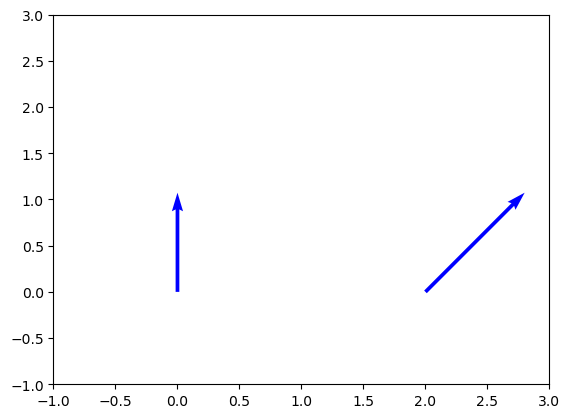

In [10]:
X=np.array([0,2])    # représente les abscisses des points
Y=np.array([0,0])    # représente les ordonnées des points
F=np.array([0,1])    # représente le vecteur f(0,0)
G=np.array([1,1])    # représente le vecteur f(1,1)
plt.quiver(X,Y,F,G,color='b',scale=5)    # met à l'échelle les vecteurs grâce à l'option scale
plt.xlim(-1, 3)   
plt.ylim(-1, 3)
plt.show()

La routine `pyplot.quiver` permet également de tracer une collection de ces vecteurs :

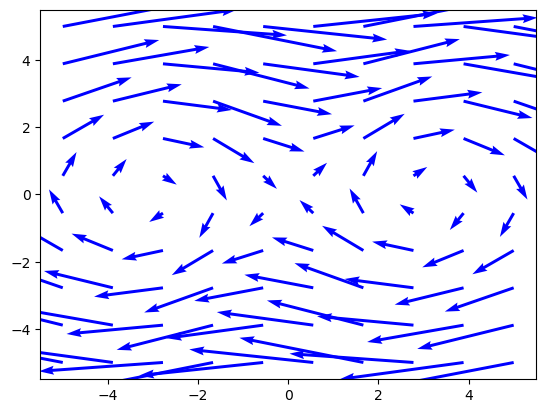

In [11]:
# Test de la fonction pyplot.quiver pour l'équation du pendule
V0,V1=np.meshgrid(np.linspace(-5, 5, 10),np.linspace(-5, 5, 10)) # représente les abscisses et les ordonnées des points 
W0=np.zeros([10,10])
W1=np.zeros([10,10])
for i in range(10):
    for j in range(10):
        W0[i,j]=f4(np.array([V0[i,j],V1[i,j]]),0)[0] # représente les abscisses et les ordonnées des vecteurs f aux points considérés
        W1[i,j]=f4(np.array([V0[i,j],V1[i,j]]),0)[1]
plt.quiver(V0,V1,W0,W1,color='b',scale=20)
plt.show()

## Exercices

### Exercice 1 : modèle de Bass pour la diffusion d'un produit.

Considérons la proportion de la population $x(t) \in [0, 1]$ qui a acquis un produit fixé à l'instant $t$. Sur un intervalle de temps infinitésimal de taille $\Delta t$, certains des individus qui n'ont pas encore ce produit peuvent innover et l'acheter avec une probabilité $p \Delta t$, où le nombre $p$ est appelé coefficient d'innovation. D'autres peuvent imiter un individu ayant déjà acquis le produit et l'acheter avec une probabilité $q\Delta t$, où le nombre $q$ est appelé coefficient d'imitation.

L'équation différentielle associée à cette description s'écrit :
$$
x'(t) = p (1 - x(t)) + q (1 - x(t)) x(t).
$$

1. Expliquer formellement pourquoi cette équation correspond bien au modèle précédemment décrit.

La description précédente du modèle de Bass assure que les individus qui possèdent le produit à l'instant $t + \Delta t$ sont :
- ceux qui le possédaient au temps $t$,
- ceux qui ont innové en l'acquérant entre le temps $t$ et le temps $t + \Delta t$,
- ceux qui ont imité des individus qui le possédaient déjà et ont donc aussi acquis le produit entre $t$ et $t + \Delta t$.

La proportion de ceux qui le possédaient déjà est égale à $x(t)$, et celle de ceux qui ont innové est égale à $p \Delta t$ fois la proportion d'invidus $1 - x(t)$ qui ne possédaient pas le produit au temps $t$. Quant à ceux qui ont imité l'achat d'autres individus, elle vaut $q$ fois la proportion des contacts entre ceux qui ont déjà et ceux qui n'ont pas encore le produit au temps $t$, soit la proportion $x(t) (1 - x(t))$.

La proportion $x(t + \Delta t)$ vaut donc
$$
x(t + \Delta t) = x(t) + p (1 - x(t)) \Delta t + q x(t) (1 - x(t)) \Delta t,
$$
ce qui conduit à l'expression
$$
\frac{x(t + \Delta t) - x(t)}{\Delta t} = p (1 - x(t)) + q x(t) (1 - x(t)).
$$
Il suffit alors de passer à la limite $\Delta t \to 0$ pour obtenir l'équation différentielle ordinaire qui décrit l'évolution de la proportion $x(t)$.

2.a. Supposons que $p = 0.5$ et $q=3$, et qu'initialement personne ne possède le produit $x(0)=0$. À l'aide des fonctions `eul_exp` ou `eul_exp2`, représenter graphiquement la solution $x$ sur le segment $[0, 2]$.

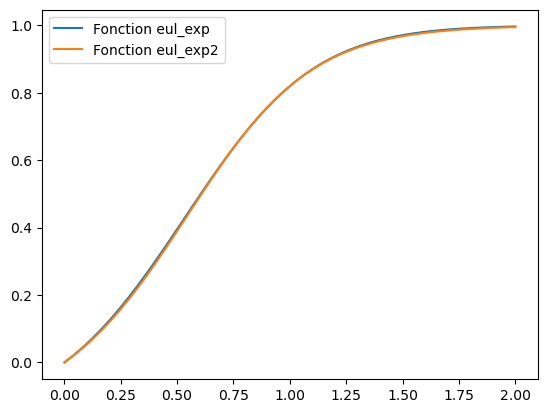

In [12]:
p=0.5
q=3
x0=np.array([0])
def g(x,t):
    return p*(1-x)+q*x*(1-x)
T=np.linspace(0,2,50)
X=[]
for t in T:
    X.append(eul_exp(g,x0[0],t,20))
plt.plot(T,X,label='Fonction eul_exp')
Y=eul_exp2(g,x0,2,49)
plt.plot(T,Y,label='Fonction eul_exp2')
plt.legend()
plt.show()

b. Que constatez-vous lorsque $t\to \infty$ ?

La proportion $x(t)$ converge vers $1$ lorsque $t \to + \infty$.

3. La fraction d'innovateurs dans la population sur l'intervalle $[t, t + \Delta t]$ est égale à $p (1-x(t)) \Delta t$. La fraction totale d'individus ayant innové jusqu'au temps $T$ vaut donc
$$
f_\text{inn} = p \int_0^T (1-x(t)) \, dt.
$$
La méthode des rectangles à gauche approche cette intégrale par la somme
$$
f_\text{rg} = p h \sum_{k=0}^{K-1} (1 - x(k h)),
$$
pour $h=T/K$ et $K \geq 1$. Lorsque la solution $x$ est calculée par la méthode d'Euler explicite pour le même pas de temps $h$, l'intégrale $f_\text{inn}$ peut être approchée par la somme
$$
S_\text{inn} = p h \sum_{k=0}^{K-1} (1-x_k),
$$
où $(x_k)_{0 \leq k \leq K}$ désigne la suite donnée par la méthode d'Euler explicite. Déduire numériquement de cette approximation la fraction d'individus ayant innové jusqu'aux temps $1$ et $2$ lorsque $x(0) = 0$.

In [13]:
S1=0
for i in range(0,25):
    S1=S1+p/25*(1-Y[i,0])
print('S(1) =',S1,'\n')
S2=0
for i in range(0,50):
    S2=S2+2*p/50*(1-Y[i,0])
print('S(2) =',S2,'\n')

S(1) = 0.30498416788589483 

S(2) = 0.33003576493006853 



4. La fraction d'imitateurs sur l'intervalle $[t, t + \Delta t]$ est égale à $q x(t) (1-x(t)) \Delta t$. La fraction totale d'imitateurs jusqu'au temps $T$ vaut donc
$$
f_\text{imi} = q \int_0^T x(t) (1 - x(t)) \, dt.
$$

a. Calculer numériquement par la même méthode qu'à la question 3. la fraction d'individus ayant imité jusqu'aux temps $1$ et $2$.

In [14]:
I1=0
for i in range(0,25):
    I1=I1+q/25*(1-Y[i,0])*Y[i,0]
print('I(1) =',I1,'\n')
I2=0
for i in range(0,50):
    I2=I2+2*q/50*(1-Y[i,0])*Y[i,0]
print('I(2) =',I2,'\n')

I(1) = 0.5097113846725628 

I(2) = 0.645778155727052 



b. Vérifier qu'au temps $2$ la somme de la fraction d'individus ayant innové et de la fraction d'individus ayant imité est égale à $1$.

In [15]:
print('Fraction totale =',I2+S2,'\n')

Fraction totale = 0.9758139206571206 



### Exercice 2.

Considérons le problème de Cauchy
$$
\begin{cases} x'(t) = x(t)^2, \\ x(0) = 1. \end{cases}
$$

1. Déterminer la valeur approchée $x_K$ de $x(2)$ donnée par la méthode d'Euler explicite via la fonction `eul_exp` pour $K = 5$, $K = 10$, $K = 15$ et $K = 20$. Que constatez-vous ?

In [16]:
x0=1
def h(x,t):
    return x**2
print('x(2) =',eul_exp(h,x0,2,5),'pour K=5 \n')
print('x(2) =',eul_exp(h,x0,2,10),'pour K=10 \n')
print('x(2) =',eul_exp(h,x0,2,15),'pour K=15 \n')
print('x(2) =',eul_exp(h,x0,2,20),'pour K=20 \n')

x(2) = 57.35520398987258 pour K=5 

x(2) = 551626.5699939575 pour K=10 

x(2) = 6.701024396348413e+22 pour K=15 

x(2) = 5.649408698813947e+103 pour K=20 



Lorsque le nombre de discrétisations $K$ augmente, la valeur des solutions approchées au temps $2$ explose.

2.a. Calculer explicitement la solution de ce problème de Cauchy.

Comme la fonction $(x, t) \mapsto x^2$ est de classe $\mathcal{C}^1$ sur $\mathbb{R}^2$, le théorème de Cauchy-Lipschitz assure qu'il existe un unique temps maximal $T$ et une unique solution maximale $x \in \mathcal{C}^1([0, T[, \mathbb{R})$ du problème de Cauchy considéré. Sachant que
$$
\forall 0 \leq t < T, \, x'(t) = x(t)^2 > 0,  
$$
cette solution est strictement croissante. Comme $x(0) = 1$, elle est donc strictement positive sur $[0, T[$. Nous pouvons donc écrire
$$
\forall 0 \leq t < T, \, \frac{x'(t)}{x(t)^2} = 1,
$$
puis en intégrant cette expression entre $0$ et $t$,
$$
\frac{1}{x(t)} = 1 - t.
$$
Comme $x$ est strictement positive sur $[0, T[$, cette identité assure que $T < 1$, puis que
$$
\forall 0 \leq t < T, \, x(t) = \frac{1}{1 - t}.
$$
Par maximalité de la solution, nous obtenons que $T = 1$ et que
$$
\forall 0 \leq t < 1, \, x(t) = \frac{1}{1 - t}.
$$

b. En déduire une explication du phénomène observée à la question 1.

La solution $x$ associée à la donne initiale $x(0) = 1$ n'est définie que sur l'intervalle $[0, 1[$. Sa limite  lorsque $t$ tend vers $1$ est égale à $+ \infty$. Ce phénomène d'explosion explique que les valeurs des solutions approchées tendent également vers $+ \infty$ pour des temps supérieurs à $1$.

### Exercice 3.

Au lieu de coder de nouveau l'algorithme de Newton-Raphson, nous aurions pu utiliser une routine de scipy.optimize.

1. Écrire une fonction `eul_imp2(f,x0,t,K)` qui prend en entrée une fonction $f$, une donnée initiale $x_0$, un temps $t$ et un entier $K$, et renvoie la solution $x(t)$ au temps $t$ de l'équation différentielle
$$
\begin{cases} x'(t) = f(x(t),t), \\ x(0) = x_0, \end{cases}
$$
par la méthode d'Euler implicite, mais avec la routine `scipy.optimize.fsolve`.


In [17]:
import scipy.optimize as sc_opt
def eul_imp2(f,x0,t,K):
    n=len(x0)
    y=np.copy(x0)
    h=t/K
    for k in range(K):
        def F_aux(x):
            return(x-h*f(x,(k+1)*h)-y)
        z=sc_opt.fsolve(F_aux,y)
        y=z
    return(y)

2. Utiliser cette fonction pour représenter la courbe de la solution du problème de Cauchy
$$
\begin{cases} x'(t) = x(t)^2, \\ x(0) = 1, \end{cases}
$$
sur le segment $[0,0.99]$. Que constatez-vous lorsque $t\to 1$ ?

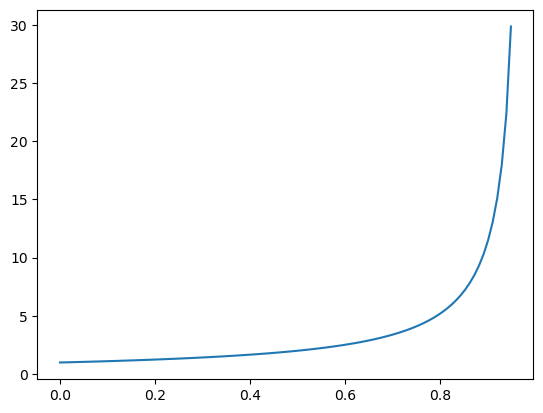

In [18]:
x0=np.array([1])
def h(x,t):
    return x**2
T=np.linspace(0,0.95,100)
X=[]
for t in T:
    X.append(eul_imp2(h,x0,t,200))
plt.plot(T,X)
plt.show()

La solution $x$ associée à la donnée intiale $x(0) = 1$ prend des valeurs qui tendent vers $+ \infty$ lorsque $t$ tend vers $1$, conformément à son expression explicite calculée dans l'exercice 2. 

### Exercice 4 : efficacité de la méthode d'Euler implicite pour des problèmes raides.

Étant donné un paramètre $\varepsilon > 0$, considérons le problème de Cauchy :
$$
\begin{cases}
x'(t) = \frac{1}{\epsilon} \big( - x(t) + \cos(t) \big), \\ x(0) = 1.
\end{cases}
$$

1. Pour $\varepsilon = 0.1$, représenter numériquement à l'aide de la fonction `eul_exp2` la courbe de la solution donnée par la méthode d'Euler explicite pour l'intervalle de temps $[0,10]$ et le pas de temps $h = 0.2$. Que constatez-vous ?

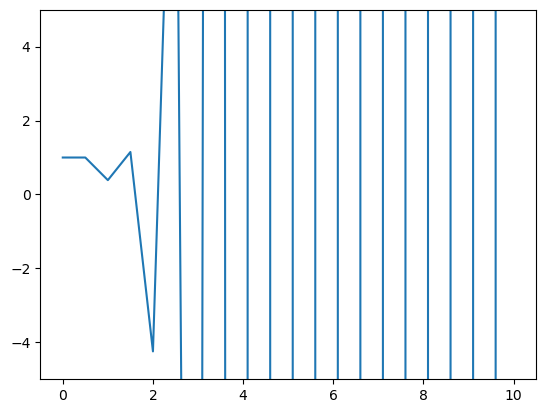

In [19]:
epsilon=0.1
def g(x,t):
    return (-x[0]+np.cos(t))/epsilon
x0=np.array([1])
T=np.linspace(0,10,21)
X1=eul_exp2(g,x0,10,20)
plt.plot(T,X1)
plt.ylim(-5,5)
plt.show()

Nous observons l'instabilité numérique de la méthode d'Euler explicite pour la résolution de cette équation différentielle. 

2. Pour $\varepsilon = 0.1$, représenter numériquement la solution donnée par la méthode d'Euler implicite pour l'intervalle de temps $[0, 10]$ et le pas de temps $h = 0.2$. Quelle évolution observez-vous par rapport au résultat de la question 1. ?

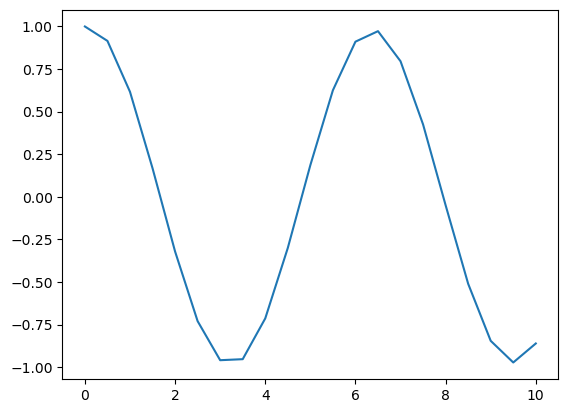

In [20]:
x0=np.array([1])
X2=[]
for t in T:
    X2.append(eul_imp2(g,x0,t,20))
plt.plot(T,X2)
plt.show()

La solution observée ne présente plus d'instabilités numériques. 

3.a. Déterminer explicitement la solution de ce problème de Cauchy.

Comme l'équation différentielle considérée est affine, la version affine du théorème de Cauchy-Lipschitz assure qu'il existe une unique solution gobale $x \in \mathcal{C}^1(\mathbb{R}, \mathbb{R})$ du problème de Cauchy considéré. Afin de calculer cette solution, nous écrivons
$$
\forall t \in \mathbb{R}, \, \big( x(t) e^\frac{t}{\varepsilon} \big)' = \Big( x'(t) + \frac{x(t)}{\varepsilon} \Big) e^\frac{t}{\varepsilon} = \frac{\cos(t) \, e^\frac{t}{\varepsilon}}{\varepsilon}.
$$
Nous déduisons de cette identité et de la condition initiale $x(0) = 1$ que
$$
x(t) = e^{- \frac{t}{\varepsilon}} \bigg( 1 + \frac{1}{\varepsilon} \int_0^t \cos(s) \, e^\frac{s}{\varepsilon} \, ds \bigg).
$$
Nous notons alors que
$$
\int_0^t \cos(s) \, e^\frac{s}{\varepsilon} \, ds = \text{Re} \bigg( \int_0^t e^{(i + \frac{1}{\varepsilon}) s} \, ds \bigg) = \text{Re} \Big( \frac{e^{(i + \frac{1}{\varepsilon}) s} - 1}{i + \frac{1}{\varepsilon}} \Big) = \frac{\varepsilon}{1+\varepsilon^2} \Big( (\cos(t) + \varepsilon \sin(t)) e^\frac{t}{\varepsilon} - 1 \Big),
$$
de sorte que
$$
x(t) = \frac{\varepsilon^2}{1 + \varepsilon^2} e^{- \frac{t}{\varepsilon}} + \frac{1}{1 + \varepsilon^2} \big( \cos(t) + \varepsilon \sin(t) \big).
$$

b. Représenter graphiquement les courbes obtenues aux questions 1. et 2., et celle obtenue par cette formule explicite.

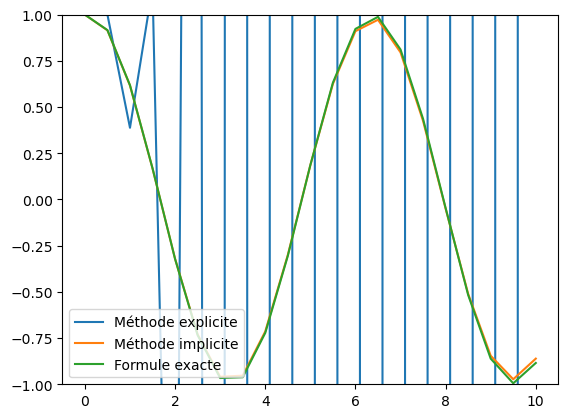

In [21]:
def sol(t):
    return epsilon**2/(1+epsilon**2)*np.exp(-t/epsilon)+(np.cos(t)+epsilon*np.sin(t))/(1+epsilon**2)
Y=sol(T)
plt.plot(T,X1,label='Méthode explicite')
plt.plot(T,X2,label='Méthode implicite')
plt.plot(T,Y,label='Formule exacte')
plt.ylim(-1,1)
plt.legend(loc='lower left')
plt.show()

c. Quelle méthode vous semble la plus efficace pour approcher la solution exacte ?

La méthode d'Euler implicite donne une approximation correcte de la solution exacte, tandis que la méthode d'Euler explicite est numériquement instable. La méthode d'Euler implicite est donc bien plus efficace.

### Exercice 5 : modèle monétariste canonique d'inflation chômage.

Ce modèle repose sur quatre équations structurelles. La première équation exprime le taux de croissance des salaires $w$ en fonction du taux de chomage $U$ et du taux d'inflation anticipé par les individus $\pi$ :
$$
w(t) = - \beta U(t) + \alpha + h\pi(t),
$$
où $\alpha > 0$, $\beta > 0$ et $0 \leq h < 1$. La deuxième équation décrit le taux d'inflation réel $p$ en fonction du taux de croissance des salaires :
$$
p(t) = w(t) - T,
$$
où $T$ est le taux de croissance de la productivité du travail supposé constant. La troisième équation décrit la variation du taux d'inflation anticipé $\pi$ par rapport au taux d'inflation réel $p$ :
$$
\pi'(t) = j (p(t) - \pi(t)),
$$
avec $0 < j \leq 1$. La quatrième équation décrit la variation du taux de chomage en fonction du taux d'inflation réel
$$
U'(t) = - k (m - p(t)),
$$
où $k > 0$, et $m$ désigne le taux de croissance de la masse monétaire supposé constant.

1.a. À l'aide des deux premières équations, exprimer le taux d'inflation réel $p$ en fonction des fonctions $U$ et $\pi$.

D'après les deux premières équations ci-dessus, la fonction $p$ vaut
$$
p(t) = - \beta U(t) + \alpha + h \pi(t) - T.
$$

b. En déduire que le vecteur $(\pi,U)$ résout l'équation différentielle :
$$
\begin{cases} \pi'(t) = j (h - 1) \pi(t) - j \beta U(t) + j (\alpha - T), \\
U'(t) = k h \pi(t) - k \beta U(t) - k (m + T - \alpha). \end{cases}
$$

Sachant que
$$
\pi'(t) = j (p(t) - \pi(t)),
$$
nous déduisons de la question 1.a que
$$
\pi'(t) = j \big( - \beta U(t) + \alpha + (h - 1) \pi(t) - T \big) = j (h - 1) \pi(t) - j \beta U(t) + j (\alpha - T).
$$
De façon similaire, nous calculons
$$
U'(t) = - k (m + \beta U(t) - \alpha - h \pi(t) + T) = k h \pi(t) - k \beta U(t) - k (m + T - \alpha).
$$

2. Fixons $\alpha = 1/2$, $T = 1/6$, $m = 5$, $h = 7/8$, $j = 3/4$ et $k = 1/2$, et choisissons $\beta = 1/2$. 

a. Tracer numériquement la courbe $\{ (\pi(t), U(t)), t \in [0, 100] \}$ des valeurs prises par la solution de donnée initiale $(\pi(0), U(0)) = (1, 1)$.

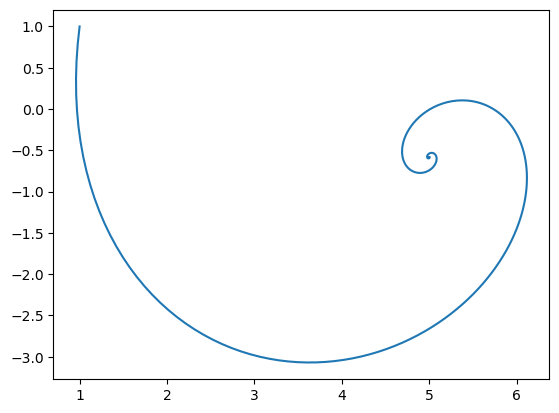

In [22]:
def G(x,t):
    return np.array([j*(h-1)*x[0]-j*beta*x[1]+j*(alpha-T),k*h*x[0]-k*beta*x[1]-k*(m+T-alpha)])
alpha=1/2
T=1/6
m=5
h=7/8
j=3/4
k=1/2
beta=1/2
X0=np.array([1,1])
X=eul_exp2(G,X0,100,1000)
plt.plot(X[:,0],X[:,1])
plt.show()

b.Tracer numériquement dans le même plan la courbe de donnée initiale $(\pi(0), U(0)) = (4, 0)$. Que constatez-vous ?

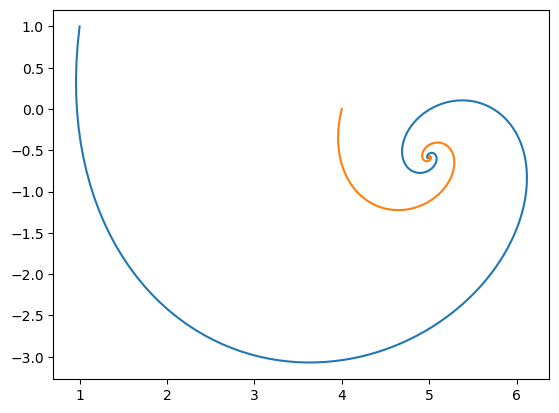

In [23]:
eta=1/2
Y0=np.array([4,0])
Y=eul_exp2(G,Y0,100,1000)
plt.plot(X[:,0],X[:,1])
plt.plot(Y[:,0],Y[:,1])
plt.show()

Nous observons que les deux trajectoires convergent vers le même point limite en spiralant autour de ce point.

3. Choisissons désormais $\beta = 10$. Tracer numériquement les courbes des solutions pour des données initiales de votre choix. Constatez-vous un changement par rapport aux trajectoires de la question 2. ?

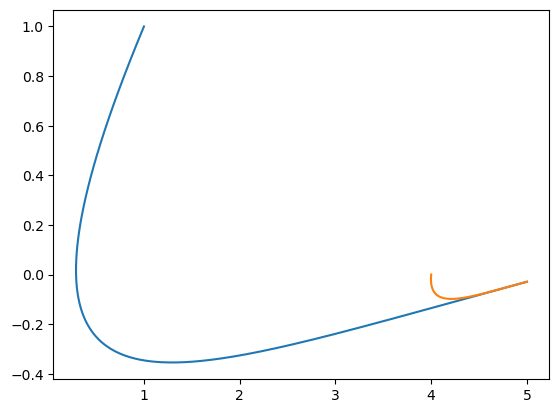

In [24]:
beta=10
Z0=np.array([1,1])
Z=eul_exp2(G,Z0,100,10000)
U0=np.array([4,0])
U=eul_exp2(G,U0,100,10000)
plt.plot(Z[:,0],Z[:,1])
plt.plot(U[:,0],U[:,1])
plt.show()

Les trajectoires continuent à converger vers un même point limite, mais ne spiralent plus autour de ce point.

4.a. Calculer numériquement, pour les choix de $\beta$ des questions 2. et 3., les valeurs propres de la matrice
$$
A = \begin{pmatrix} j (h - 1) & - j \beta \\ k h & - k \beta \end{pmatrix}.
$$


In [25]:
beta=1/2
A=np.array([[j*(h-1),-j*beta],[k*h,-k*beta]])
val1=np.linalg.eig(A)[0]
print('Spectre de A =',val1,'\n')
beta=10
A=np.array([[j*(h-1),-j*beta],[k*h,-k*beta]])
val2=np.linalg.eig(A)[0]
print('Spectre de A =',val2,'\n')

Spectre de A = [-0.171875+0.39744054j -0.171875-0.39744054j] 

Spectre de A = [-0.89261617 -4.20113383] 



b. En déduire une explication des résultats numériques obtenus aux questions 2. et 3.

Notons
$$
\forall 0 \leq t \leq 100, \, X(t) = \begin{pmatrix} \pi(t) \\ U(t) \end{pmatrix}.
$$
Nous pouvons alors écrire le système différentiel considéré sous la forme
$$
X'(t) = A X(t) + V,
$$
où le vecteur $V$ est égal à
$$
V = \begin{pmatrix} j (\alpha - T) \\ - k (m + T - \alpha) \end{pmatrix}.
$$
Nous calculons alors
$$
\big( e^{- t A} X(t) \big)' = e^{- t A} \big( X'(t) - A X(t) \big) = e^{- t A} V,
$$
de sorte que
$$
X(t) = e^{t A} X(0) + \int_0^t e^{(t - s) A} V \, ds.
$$
Dans les deux cas où $\beta = 1/2$ et $\beta = 10$, nous observons que $0$ n'est pas une valeur propre de la matrice $A$. Cette matrice est donc inversible et nous pouvons écrire
$$
\int_0^t e^{(t - s) A} V \, ds = \int_0^t e^{(t - s) A} A A^{-1} V \, ds = - \int_0^t \frac{d}{ds} \big( e^{(t - s) A} A^{-1} V \big) \, ds = - A^{- 1} V + e^{t A} A^{- 1} V,
$$
ce qui conduit à l'expression finale
$$
X(t) = - A^{- 1} V + e^{t A} \big( X(0) + A^{- 1} V \big).
$$
Dans les deux cas où $\beta = 1/2$ et $\beta = 10$, les deux valeurs propres de la matrice $A$ sont de partie réelle strictement négative, et nous savons donc par le critère de Routh que
$$
e^{t A} \underset{t \to + \infty}{\to} 0,
$$
ce qui assure que
$$
X(t) \underset{t \to + \infty}{\to} - A^{- 1} V.
$$
C'est cette convergence que nous observons sur les tracés précédents avec des courbes qui convergent toutes vers un point limite.

La différence d'allure entre les deux courbes tient au fait que dans le cas où $\beta = 1/2$, les deux valeurs propres conjuguées possèdent une partie imaginaire non nulle, tandis que les deux valeurs propres sont réelles dans le cas où $\beta = 10$. Dans le premier cas, la convergence correspond donc à celle d'un foyer attractif pour lequel les trajectoires spiralent autour du point limite, tandis que dans le second cas, elle correspond à celle d'un noeud attractif pour lequel les trajectoires visent directement le point limite.  

### Exercice 6.

Considérons le problème de Cauchy
$$
\begin{cases} x'(t)=f(x(t),t), \\ x(0)=x_0. \end{cases}
$$

1. Définir une fonction `integrate(phi,x0,t)` qui pour une liste de temps $(t_i)_ {i=0}^N$ donnée, retourne les valeurs approchées $x_0$, $x_1$, $\ldots$, $x_N$ associées à la méthode à un pas correspondante à la fonction $\phi$.

In [26]:
def integrate(phi,x0,t):
    N=len(t)
    X=[x0]
    for i in range(1,N):
        X.append(X[-1]+phi(f,t[i-1],X[-1],t[i]-t[i-1]))
    return X    

2.a. Implémenter les fonctions `phi(f,t,x,h)` de résolution par la méthode d'Euler explicite et la méthode de Runge-Kutta d'ordre deux.

In [27]:
def phi_Eul_exp(f,t,x,h):
    return h*f(x,t)
def phi_RK2(f,t,x,h):
    return h*f(x+h/2*f(x,t),t+h/2)

b. Comparer ces deux méthodes sur l'exemple d'une équation différentielle de votre choix.

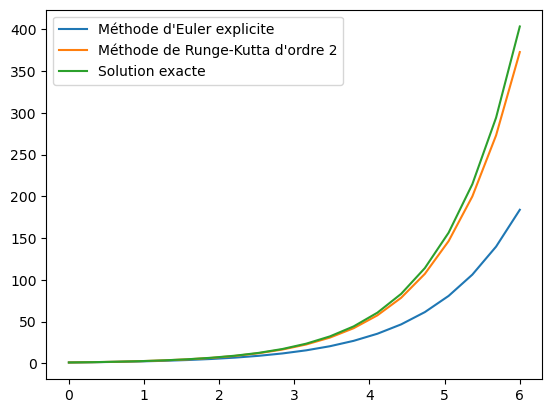

In [28]:
# Test pour l'équation différentielle x'(t)=x(t) dont la solution
# pour x(0)=1 est la fonction exponentielle
def f(x,t):
    return x
x0=1
T=np.linspace(0,6,20)
X=integrate(phi_Eul_exp,x0,T)
Y=integrate(phi_RK2,x0,T)
plt.plot(T,X,label="Méthode d'Euler explicite")
plt.plot(T,Y,label="Méthode de Runge-Kutta d'ordre 2")
plt.plot(T,np.exp(T),label='Solution exacte')
plt.legend()
plt.show()

3.a. Implémenter la fonction `phi(f,t,x,h)` de résolution par la méthode de Runge-Kutta d'ordre quatre.

In [29]:
def phi_RK4(f,t,x,h):
    k1=f(x,t)
    k2=f(x+k1*h/2,t+h/2)
    k3=f(x+k2*h/2,t+h/2)
    k4=f(x+k3*h,t+h)
    return h/6*(k1+2*k2+2*k3+k4)

b. Comparer avec la méthode d'ordre deux.

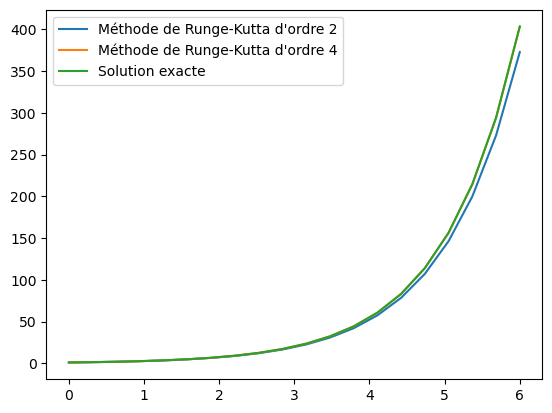

In [30]:
Z=integrate(phi_RK4,x0,T)
plt.plot(T,Y,label="Méthode de Runge-Kutta d'ordre 2")
plt.plot(T,Z,label="Méthode de Runge-Kutta d'ordre 4")
plt.plot(T,np.exp(T),label='Solution exacte')
plt.legend()
plt.show()

### Exercice 7.

Considérons le système de Lotka-Volterra : 
$$
\begin{cases}
x′(t) = x(t) \big( 1 − \frac{y(t)}{5} \big), \\
y′(t) = y(t) \big( \frac{x(t)}{5} − 2 \big).
\end{cases}
$$

1. Tracer dans l’espace des phases la trajectoire de la solution qui a pour donnée initiale $(x_0, y_0) = (15, 10)$ (pour $t\in [0, 10]$).

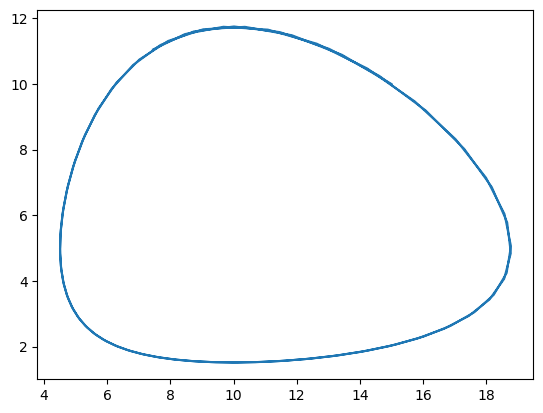

In [31]:
def LV(x,t):
    return np.array([x[0]*(1-x[1]/5),x[1]*(x[0]/5-2)])
x0=np.array([15,10])
T=np.linspace(0,10,100)
X0=sc_int.odeint(LV,x0,T)
plt.plot(X0[:,0],X0[:,1])
plt.show()

2. Tracer les isoclines $\{ x' = 0 \}$ et $\{ y' = 0 \}$ dans l’espace des phases.

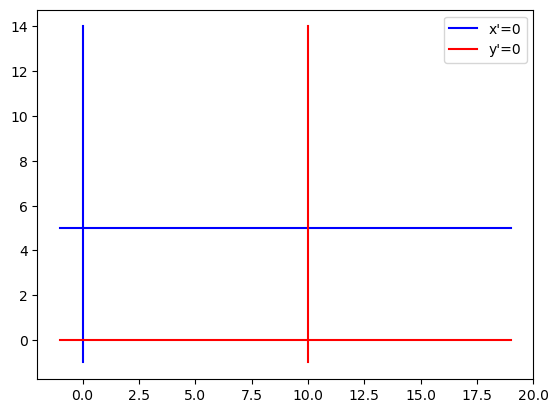

In [32]:
iso1=5*np.ones([100,2])
iso1[:,0]=np.linspace(-1,19,100)
plt.plot(iso1[:,0],iso1[:,1],color='blue',label="x'=0")
iso2=np.zeros([100,2])
iso2[:,1]=np.linspace(-1,14,100)
plt.plot(iso2[:,0],iso2[:,1],color='blue')
iso3=10*np.ones([100,2])
iso3[:,1]=np.linspace(-1,14,100)
plt.plot(iso3[:,0],iso3[:,1],color='red',label="y'=0")
iso4=np.zeros([100,2])
iso4[:,0]=np.linspace(-1,19,100)
plt.plot(iso4[:,0],iso4[:,1],color='red')
plt.legend()
plt.show()

3. Ajouter dans l'espace des phases d’autres trajectoires que celle issue des données initiales $(15, 10)$. 

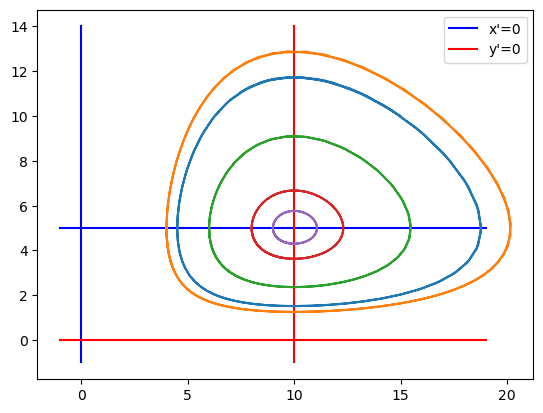

In [33]:
plt.plot(iso1[:,0],iso1[:,1],color='blue',label="x'=0")
plt.plot(iso2[:,0],iso2[:,1],color='blue')
plt.plot(iso3[:,0],iso3[:,1],color='red',label="y'=0")
plt.plot(iso4[:,0],iso4[:,1],color='red')
x1=np.array([4,5])
X1=sc_int.odeint(LV,x1,T)
x2=np.array([6,5])
X2=sc_int.odeint(LV,x2,T)
x3=np.array([8,5])
X3=sc_int.odeint(LV,x3,T)
x4=np.array([9,5])
X4=sc_int.odeint(LV,x4,T)
plt.plot(X0[:,0],X0[:,1])
plt.plot(X1[:,0],X1[:,1])
plt.plot(X2[:,0],X2[:,1])
plt.plot(X3[:,0],X3[:,1])
plt.plot(X4[:,0],X4[:,1])
plt.legend()
plt.show()

4. Représenter le champ de vecteur $(x,y) \mapsto (x (1 - y/5), y(x/5 - 2))$ pour compléter le portrait de phase.

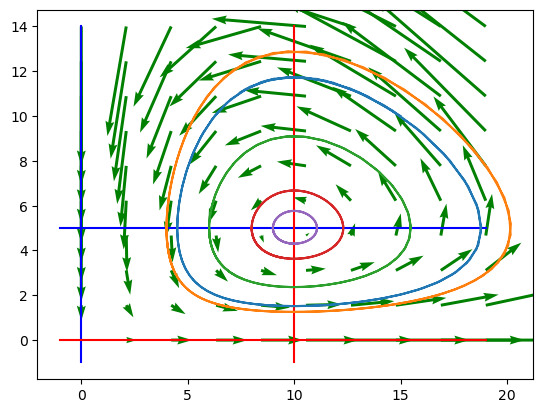

In [34]:
V0,V1=np.meshgrid(np.linspace(0,19,10),np.linspace(0,14,10)) 
W0=np.zeros([10,10])
W1=np.zeros([10,10])
for i in range(10):
    for j in range(10):
        W0[i,j]=LV(np.array([V0[i,j],V1[i,j]]),0)[0]
        W1[i,j]=LV(np.array([V0[i,j],V1[i,j]]),0)[1]
plt.quiver(V0,V1,W0,W1,color='green',scale=100)
plt.plot(iso1[:,0],iso1[:,1],color='blue',label="x'=0")
plt.plot(iso2[:,0],iso2[:,1],color='blue')
plt.plot(iso3[:,0],iso3[:,1],color='red',label="y'=0")
plt.plot(iso4[:,0],iso4[:,1],color='red')
plt.plot(X0[:,0],X0[:,1])
plt.plot(X1[:,0],X1[:,1])
plt.plot(X2[:,0],X2[:,1])
plt.plot(X3[:,0],X3[:,1])
plt.plot(X4[:,0],X4[:,1])
plt.show()

### Exercice 8.

1. Par la méthode numérique de votre choix, représenter la solution du système de Lorenz :
$$
\begin{cases} x'(t) = 10 (y(t) - x(t)), \\
y'(t) = - x(t) z(t) + 28 x(t) - y(t), \\
z'(t) = x(t) y(t) - \frac{8}{3} z(t),
\end{cases}
$$
pour les données initiales $x(0) = - 3$, $y(0) = - 6$ et $z(0) = 12$, sur l'intervalle $[0, 50]$.

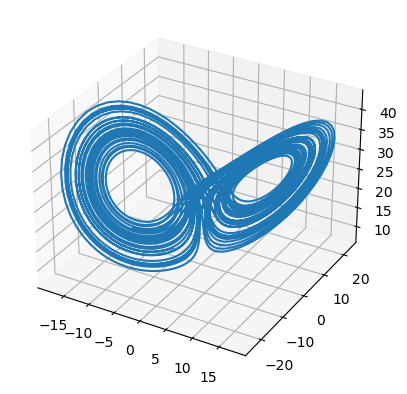

In [35]:
x0=np.array([-3,-6,12])
def L(x,t):
    return np.array([10*(x[1]-x[0]),-x[0]*x[2]+28*x[0]-x[1],x[0]*x[1]-8*x[2]/3])
T=np.linspace(0,50,5000)
U=sc_int.odeint(L,x0,T)
X=U[:,0]
Y=U[:,1]
Z=U[:,2]
plt.axes(projection='3d')
plt.plot(X,Y,Z)
plt.show()

2. Au niveau numérique, observez-vous une stabilisation de la solution ?

La solution ne se stabilise pas autour d'un point d'équilibre, ou d'une orbite périodique, mais se rapproche d'une structure limite appellée attracteur de Lorenz.